In [9]:
!git clone https://github.com/imostafizur/CSE498R.git

fatal: destination path 'CSE498R' already exists and is not an empty directory.


## Pneumonia Detection with InceptionV3

In [10]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import TerminateOnNaN
from tensorflow.keras.callbacks import ProgbarLogger
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import BaseLogger
from tensorflow.keras.callbacks import RemoteMonitor
from tensorflow.keras.callbacks import CallbackList
from tensorflow.keras.callbacks import Callback

In [11]:
image = ('Pneumonia')

In [12]:
print('Total number of images in Pneumonia folder:', len(os.listdir('Pneumonia')))
print('Total number of images in Normal folder:',
      len(os.listdir('Pneumonia/NORMAL')))
print('Total number of images in Pneumonia folder:',
      len(os.listdir('Pneumonia/PNEUMONIA')))


Total number of images in Pneumonia folder: 2
Total number of images in Normal folder: 1342
Total number of images in Pneumonia folder: 3876


In [13]:
# InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

# Compile the model
model.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=0.0001),
                metrics=['accuracy'])

87924736/87910968 [==============================] - 1s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f274d682150> False
<keras.layers.convolutional.Conv2D object at 0x7f27b8ec5790> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2749ee6050> False
<keras.layers.core.activation.Activation object at 0x7f27b8ec52d0> False
<keras.layers.convolutional.Conv2D object at 0x7f27301664d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2730109990> False
<keras.layers.core.activation.Activation object at 0x7f273010b050> False
<keras.layers.convolutional.Conv2D object at 0x7f273010fa50> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2730116fd0> False
<keras.layers.core.activation.Activation object at 0x7f2730111450> False
<keras.layers.pooling.MaxPooling2D object at 0x7f273010b490> False
<keras.layers.convolutional.Conv2D object at 0x7f273011ed90> False
<keras.layers.n

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [15]:
# Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=30,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

In [16]:
# Data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
# Data augmentation
val_datagen = ImageDataGenerator(rescale=1./255)


In [18]:
# Data augmentation
train_generator = train_datagen.flow_from_directory(
        'Pneumonia',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 5216 images belonging to 2 classes.


In [19]:
# Data augmentation
test_generator = test_datagen.flow_from_directory(
        'Pneumonia',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 5216 images belonging to 2 classes.


In [20]:
# Data augmentation
val_generator = val_datagen.flow_from_directory(
        'Pneumonia',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 5216 images belonging to 2 classes.


In [21]:
# Callbacks
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                mode='auto')

In [22]:
# Callbacks
earlystop = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=5,
                            verbose=0,
                            mode='auto')

In [23]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=3,
                                verbose=0,
                                mode='auto')

In [24]:
# Callbacks
tensorboard = TensorBoard(log_dir='logs',
                            histogram_freq=0,
                            write_graph=True,
                            write_images=True)

In [25]:
# Callbacks
csv_logger = CSVLogger('log.csv',
                        append=False,
                        separator=',')

In [26]:

# Callbacks
lambda_callback = LambdaCallback(on_epoch_begin=None,
                                    on_epoch_end=None,
                                    on_batch_begin=None,
                                    on_batch_end=None,
                                    on_train_begin=None,
                                    on_train_end=None)

In [27]:
# Callbacks
terminate_on_nan = TerminateOnNaN()

In [31]:
# Training
history = model.fit_generator(
        train_generator,
        steps_per_epoch=5216 // 32,
        epochs=100,
        validation_data=val_generator,
        validation_steps=624 // 32,
        callbacks=[checkpoint, earlystop, reduce_lr, tensorboard, csv_logger, lambda_callback, terminate_on_nan])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
163/163 [==============================] - 85s 523ms/step - loss: 0.1885 - accuracy: 0.9283 - val_loss: 0.1494 - val_accuracy: 0.9424 - lr: 4.0000e-06
Epoch 2/100
163/163 [==============================] - 81s 498ms/step - loss: 0.1881 - accuracy: 0.9250 - val_loss: 0.1493 - val_accuracy: 0.9408 - lr: 4.0000e-06
Epoch 3/100
163/163 [==============================] - 84s 517ms/step - loss: 0.1834 - accuracy: 0.9289 - val_loss: 0.1448 - val_accuracy: 0.9293 - lr: 4.0000e-06
Epoch 4/100
163/163 [==============================] - 85s 522ms/step - loss: 0.1826 - accuracy: 0.9293 - val_loss: 0.1415 - val_accuracy: 0.9375 - lr: 4.0000e-06
Epoch 5/100
163/163 [==============================] - 84s 517ms/step - loss: 0.1883 - accuracy: 0.9277 - val_loss: 0.1401 - val_accuracy: 0.9457 - lr: 4.0000e-06
Epoch 6/100
163/163 [==============================] - 81s 498ms/step - loss: 0.1780 - accuracy: 0.9293 - val_loss: 0.1503 - val_accuracy: 0.9375 - lr: 4.0000e-06
Epoch 7/100
163/163 [=

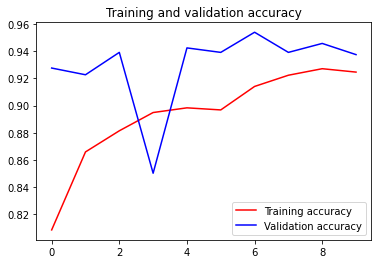

<Figure size 432x288 with 0 Axes>

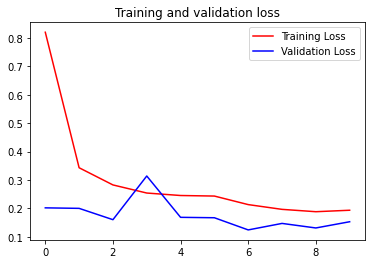

<Figure size 432x288 with 0 Axes>

In [30]:
#Plot the accuracy and loss curves for training and validation
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()


In [ ]:
#Accuracy
print('Accuracy: ', score[1]*100)
#Loss
print('Loss: ', score[0])

In [32]:
# Save the model h5
model.save('Pneumonia_InceptionV3.h5')